### Setup

In [1]:
!pip install kaggle

In [3]:
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### Importing Dataset for Pets' Facial Expression Images


In [4]:
!kaggle datasets download -d anshtanwar/pets-facial-expression-dataset

 91% 35.0M/38.6M [00:01<00:00, 37.5MB/s]
100% 38.6M/38.6M [00:01<00:00, 26.2MB/s]


In [5]:
from zipfile import ZipFile
dataset = '/content/pets-facial-expression-dataset.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [6]:
!ls

 Angry	 kaggle.json	  Other				       Sad
 happy	'Master Folder'   pets-facial-expression-dataset.zip   sample_data


### Importing Dependencies

In [10]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from keras.utils import to_categorical

from keras.layers import Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn

# manipulte zipped imgs
import cv2
from tqdm import tqdm
from random import shuffle
from zipfile import ZipFile
from PIL import Image

### Preprocessing Data, Splitting into Train and Test

In [27]:
DIR = r"/content/data"

X=[]
Z=[]
IMG_SIZE=150
HAPPY_DIR= r"/content/data/happy"
SAD_DIR= r"/content/data/sad"
ANGRY_DIR= r"/content/data/angry"
OTHER_DIR= r"/content/data/other"

In [62]:
def assignLabel(img,expressionType):
  return expressionType

def makeTrainData(expressionType, DIR):
  for img in tqdm(os.listdir(DIR)):
    label = assignLabel(img, expressionType)
    path = os.path.join(DIR, img)
    print(path)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    X.append(np.array(img))
    Z.append(str(label))

In [29]:
makeTrainData("Happy", HAPPY_DIR)
print(len(X))

makeTrainData("Sad", SAD_DIR)
print(len(X))

makeTrainData("Angry", ANGRY_DIR)
print(len(X))

makeTrainData("Other", OTHER_DIR)
print(len(X))

100%|██████████| 250/250 [00:00<00:00, 692.68it/s]


250


100%|██████████| 250/250 [00:00<00:00, 572.55it/s]


500


100%|██████████| 250/250 [00:00<00:00, 599.13it/s]


750


100%|██████████| 250/250 [00:00<00:00, 604.63it/s]

1000


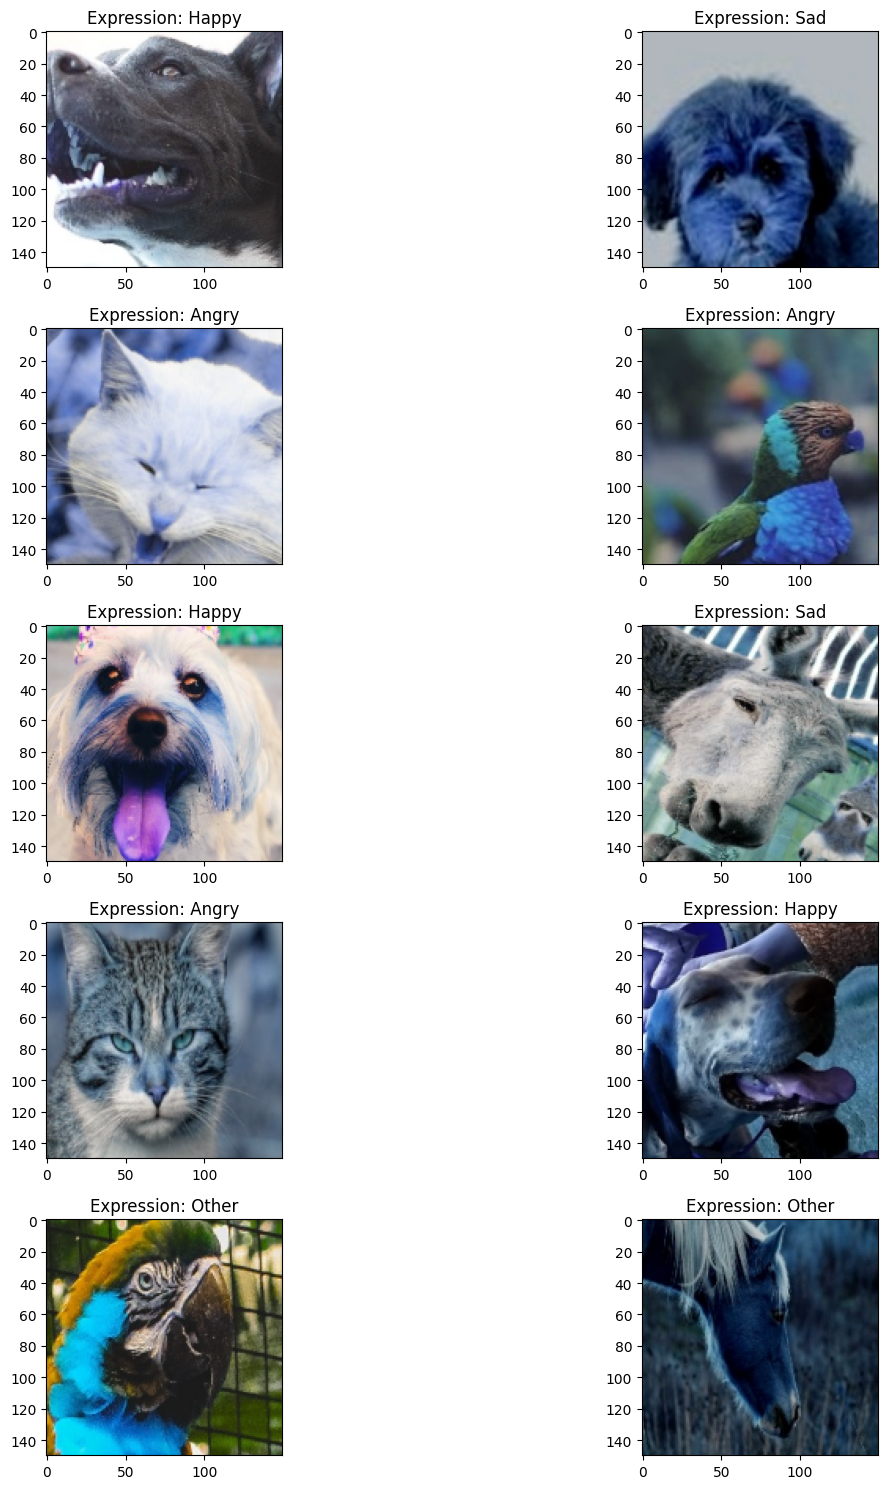

In [33]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
  for j in range(2):
    l = rn.randint(0,len(X))
    ax[i,j].imshow(X[l])
    ax[i,j].set_title("Expression: " + Z[l])

plt.tight_layout()

In [34]:
le = LabelEncoder()
Y = le.fit_transform(Z)
Y = to_categorical(Y,5)
X = np.array(X)
X = X/255 # to eliminate bias in our neural network

In [40]:
xTrain, xTest, yTrain, yTest = train_test_split(X,Y,test_size=0.25, random_state=40)
# TODO: Split the data into three portions - 2 for training and 1 for testing; cycle three times and check prediction accuracy

In [41]:
np.random.seed(40)
rn.seed(40)
tf.random.set_seed(40)

### Creating the Model

In [46]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = "Same", activation = "relu", input_shape = (150, 150, 3)))
model.add(MaxPooling2D(pool_size= (2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = "Same", activation = "relu"))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3), padding = "Same", activation = "relu"))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3), padding = "Same", activation = "relu"))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dense(5, activation = "softmax"))

In [54]:
batch_size = 128
epochs = 20

from keras.callbacks import ReduceLROnPlateau
red_lr = ReduceLROnPlateau(monitor = "val_acc", patience = 3, verbose = 1, factor = 0.1)

In [55]:
datagen = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    featurewise_std_normalization = False,
    samplewise_std_normalization = False,
    zca_whitening = False,
    rotation_range = 0.1,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True, # benefit: upsize data 2x
    vertical_flip = False)

In [56]:
# Building the model
model.compile(optimizer = Adam(learning_rate = 0.001), loss = "categorical_crossentropy", metrics = ["accuracy"])

In [57]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 75, 75, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 37, 37, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 18, 18, 96)       

In [58]:
History = model.fit_generator(datagen.flow(xTrain, yTrain, batch_size = batch_size),
                              epochs = epochs, validation_data = (xTest, yTest),
                              verbose = 1, steps_per_epoch = xTrain.shape[0] // batch_size)

<ipython-input-58-1222c4c960f4>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  History = model.fit_generator(datagen.flow(xTrain, yTrain, batch_size = batch_size),


Epoch 1/20
5/5 [==============================] - 45s 9s/step - loss: 1.3992 - accuracy: 0.2846 - val_loss: 1.3534 - val_accuracy: 0.3960
Epoch 2/20
5/5 [==============================] - 43s 9s/step - loss: 1.3812 - accuracy: 0.3312 - val_loss: 1.3726 - val_accuracy: 0.3200
Epoch 3/20
5/5 [==============================] - 43s 8s/step - loss: 1.3606 - accuracy: 0.3376 - val_loss: 1.3136 - val_accuracy: 0.3600
Epoch 4/20
5/5 [==============================] - 42s 8s/step - loss: 1.3435 - accuracy: 0.3264 - val_loss: 1.3247 - val_accuracy: 0.3440
Epoch 5/20
5/5 [==============================] - 43s 8s/step - loss: 1.3206 - accuracy: 0.3360 - val_loss: 1.2937 - val_accuracy: 0.3400
Epoch 6/20
5/5 [==============================] - 43s 8s/step - loss: 1.3021 - accuracy: 0.3553 - val_loss: 1.2789 - val_accuracy: 0.4040
Epoch 7/20
5/5 [==============================] - 43s 9s/step - loss: 1.2999 - accuracy: 0.3842 - val_loss: 1.2664 - val_accuracy: 0.4080
Epoch 8/20
5/5 [==================

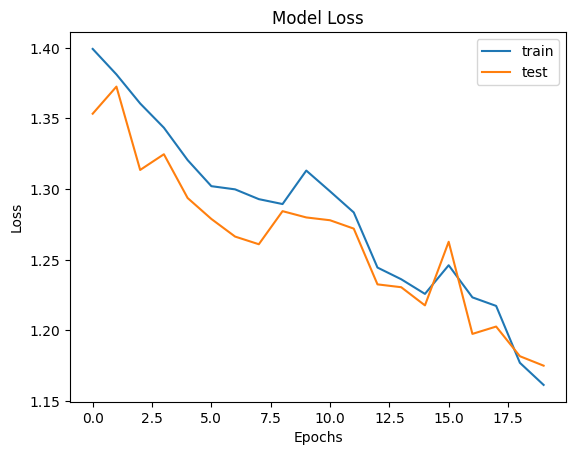

In [60]:
plt.plot(History.history["loss"])
plt.plot(History.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

### Prediction System

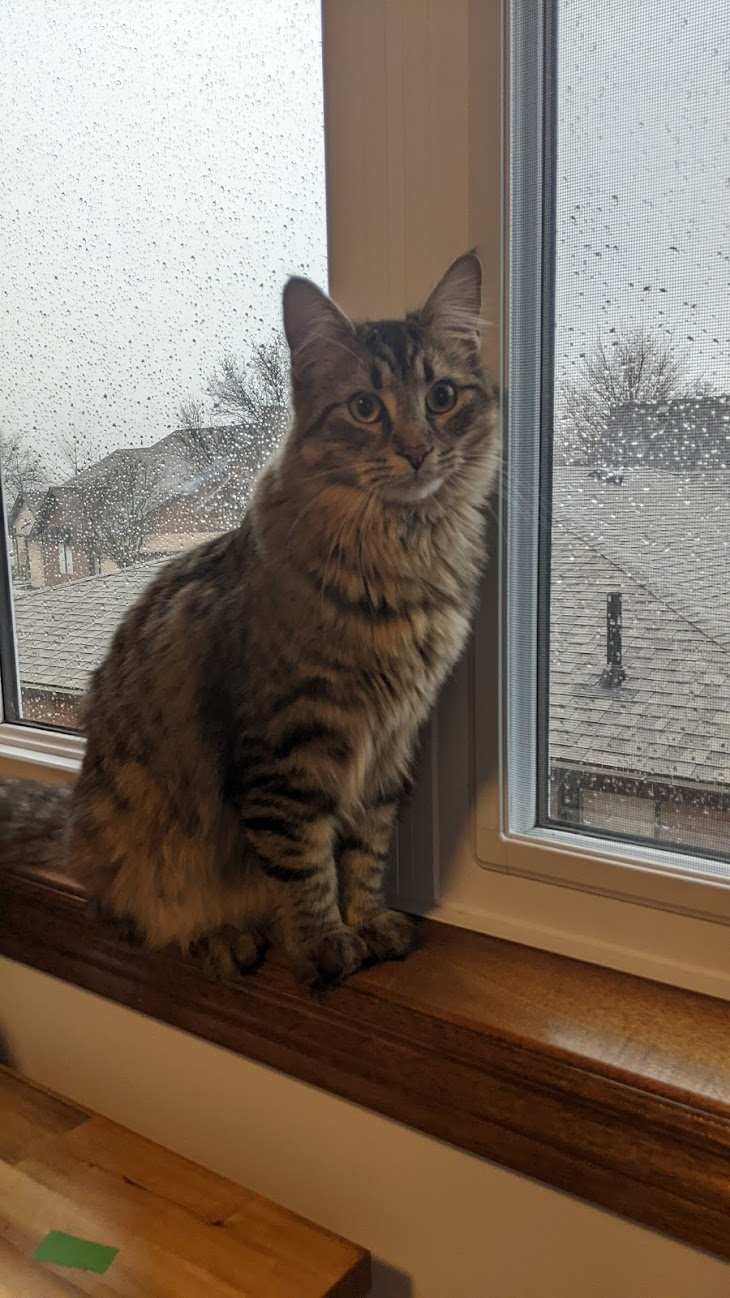

1/1 [==============================] - 0s 199ms/step
Your pet looks happy


In [109]:
from google.colab.patches import cv2_imshow

input_image = cv2.imread("/content/Paula.PNG")

cv2_imshow(input_image)

input_image_resized = cv2.resize(input_image, (150,150))

input_image_scaled = input_image_resized/255

input_image_reshaped = np.reshape(input_image_scaled, [1,150,150,3])

input_prediction = model.predict(input_image_reshaped)
# print(input_prediction)

input_pred_label = np.argmax(input_prediction)
# print("input_pred_label")
# print(input_pred_label)

if input_pred_label == 0:
  print('Your pet looks sad')

elif input_pred_label == 1:
  print("Your pet looks happy")

elif input_pred_label == 2:
  print("Your pet looks angry")

else:
  print("Inconclusive")